In [ ]:
#Libraries for data processing
import numpy as np 
import pandas as pd
import csv

#Libraries for data graphing
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set(color_codes = True)
sns.set(font_scale=1.5) # fixe la taille de la police à 1.5 * 12pt

#Libraries for artificial neural networks
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
from keras.models import Sequential
from keras.layers import Activation, Dense, Normalization
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from sklearn.preprocessing import MinMaxScaler

Link google colab and google drive

In [ ]:
from logging import RootLogger
# Mount Google Drive
from google.colab import drive # import drive from google colab

root = "/content/drive"     # default location for the drive

drive.mount(root)           # we mount the google drive at /content/drive

# import join used to join ROOT path and MY_GOOGLE_DRIVE_PATH
from os.path import join  

# path to your project on Google Drive
my_google_drive_path = "MyDrive/StudentProject2023"

project_path = join(root, my_google_drive_path)

Mounted at /content/drive


In [ ]:
#Open AMA document
mass_file = open(join(project_path,"raw_data/mass_1.mas20.txt"),"r+")

#Extract data from AMA mass data into a numpy array and csv file
#We should have 3378 entries in .csv doc, so 3377 elements in it

element_list = mass_file.readlines()

#We initialize our arrays : if we don't we can't use append() method
#We will supress these rows later
mass_array = np.ones((1,12))



#We create .csv files to use the pandas library later

mass_csv = open(join(project_path,"processed_data/mass_data.csv"),"w+")
csv_header_row = "N-Z;N;Z;A;Mass_excess;ME_unc;BE/A;BE/A_unc;Beta_decay_Energy;BDE_unc;Atomic_Mass;AM_unc\n"
mass_csv.writelines(csv_header_row)


#The following lines are for the purpose of standardization of the data
#As the data is in a complicated format (some values are empty) and thus
#we need to process the data ourselves

for element in element_list :

    
    splitted_line = element.split() #Split a string separated by spaces
    #We will get a list of 15 elements in the end

    #All elements have a column with only "B-" written
    if splitted_line.index("B-") == 11 : 
        #We want to get rid of indices 0 and 6
        splitted_line.pop(0) 
        splitted_line.pop(5) #5 as index 0 is already removed by .pop(0)
    
    if splitted_line.index("B-") == 10 :
        if (int(splitted_line[1]) - int(splitted_line[2]) == int(splitted_line[0]) and 
            int(splitted_line[1]) + int(splitted_line[2]) == int(splitted_line[3])) :
            splitted_line.pop(5)
        else : #The only other possibility is 9 which is what we look for
            splitted_line.pop(0)
    
    if len(splitted_line) != 15 :
        #Beta-decay energies uncertainties are sometimes empty, we add a 0
        splitted_line.insert(11,"0") 
        

    
    #We get rid of element symbol and "B-" in the list
    #We now have list of 13 elements
    if splitted_line[10].find("*") != -1 :
        splitted_line[10] = "0" #Replace "*" by "0"
    
    splitted_line.pop(4) #Getting rid of element symbols
    splitted_line.pop(8) #Getting rid of "B-" string

    #Values for atomic_mass follow a strange format
    #We thus concatenate two columns
    #index 10 & 11
    atomic_mass_coma = splitted_line.pop(11)
    atomic_mass_coma = "." + atomic_mass_coma.replace(".","")
    splitted_line[10] = splitted_line[10] + atomic_mass_coma
    
    
    #We now have list of 12 elements

    #Remove "#" and standardization of the list in order to convert into array
    for i in range(12) :
        if splitted_line[i].find("#") != -1 :
            splitted_line[i] = splitted_line[i].replace("#","")

    mass_csv.writelines(";".join(splitted_line) + "\n")
    #train_mass_csv.writelines(";".join(splitted_line) + "\n")
    
    #We have to use the same loop again as mass_csv need string and 
    #train_array need double format
    for i in range(12) :
        splitted_line[i] = np.double(splitted_line[i])

    mass_array = np.vstack([mass_array,np.asarray(splitted_line)])
    

#We suppress the first rows of our arrays
mass_array = np.delete(mass_array,0,0)





In [ ]:
#Create the two neutron separation energy column

#To hide warnings because sometimes we don't have the n-2 data
#Thus we can't subtract
%%capture --no-display

mass_data = pd.read_csv(join(project_path,"processed_data/mass_data.csv"),sep=";")


diff_n = [0 for i in range(len(mass_data))]

for i in range(0,119) :
    for j in mass_data["N"][mass_data["Z"]==i]:
        n = mass_data[mass_data["Z"]==i][mass_data["N"]==j]
        n_minus_two = mass_data[mass_data["Z"]==i][mass_data["N"]==j-2]
        index = n.index.values[0]
        sub = np.double(n["BE/A"]) - np.double(n_minus_two["BE/A"])
        
        if type(sub)==np.double :
            diff_n[index] = sub * np.double(n["A"])
        else :
            diff_n[index] = 0



mass_data["S2n"] = diff_n

#Same for the two proton separation energy

diff_z = [0 for i in range(len(mass_data))]

for i in range(0,178) :
    for j in mass_data["Z"][mass_data["N"]==i]:
        z = mass_data[mass_data["N"]==i][mass_data["Z"]==j]
        z_minus_two = mass_data[mass_data["N"]==i][mass_data["Z"]==j-2]
        index = z.index.values[0]
        sub = np.double(z["BE/A"]) - np.double(z_minus_two["BE/A"])
        
        if type(sub)==np.double :
            diff_z[index] = sub * np.double(z["A"])
        else :
            diff_z[index] = 0

mass_data["S2z"] = diff_z




In [ ]:
#From mass_data, we will separate train_data and validation_data

train_array = np.ones((1,12))
validation_array = np.ones((1,12))


train_data = pd.DataFrame(columns=["N-Z","N","Z","A","Mass_excess","ME_unc","BE/A","BE/A_unc","Beta_decay_Energy","BDE_unc","Atomic_Mass","AM_unc"])
validation_data = pd.DataFrame(columns=["N-Z","N","Z","A","Mass_excess","ME_unc","BE/A","BE/A_unc","Beta_decay_Energy","BDE_unc","Atomic_Mass","AM_unc"])



for i in range(3558) :
    
    if int(mass_data.iloc[i]["Z"]) in [10,38,54,68,82] :
        validation_data=validation_data.append(mass_data.iloc[i], ignore_index=True)

    else :
        train_data=train_data.append(mass_data.iloc[i], ignore_index=True)


train_csv=train_data.to_csv(join(project_path,"train_data.csv"),sep=";")
validation_csv=validation_data.to_csv(join(project_path,"validation_data.csv"),sep=";")

train_array = np.delete(train_array,0,0)
validation_array = np.delete(validation_array,0,0)



Check if tensorflow is well configured and if it detects your GPU

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print("Num GPUs available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs available:  1


In [ ]:
#We extract a keras train dataset from the .csv file
#Batch_size=11 because it is a divisor of 3377 (could have been 307)
#Talk about pros and cons of small batch size ?
#https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network



target = train_data["BE/A"]
n_input = train_data["N"]
z_input = train_data["Z"]


#ANN work best when using data between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_n = scaler.fit_transform(pd.Series.to_numpy(n_input).reshape(-1,1))
scaled_z = scaler.fit_transform(pd.Series.to_numpy(z_input).reshape(-1,1))
scaled_target = scaler.fit_transform(pd.Series.to_numpy(target).reshape(-1,1))


In [ ]:
#ANN Model

input1 = keras.layers.Input(shape=(1,))
input2 = keras.layers.Input(shape=(1,))
merged = keras.layers.Concatenate()([input1, input2])
dense1 = keras.layers.Dense(64, input_dim=2, activation="relu")(merged)
dense2 = keras.layers.Dense(64, activation="relu")(dense1)
dense3 = keras.layers.Dense(64, activation="relu")(dense2)
output = keras.layers.Dense(1, activation="relu")(dense3)
model = keras.models.Model(([input1, input2]),output)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 concatenate_2 (Concatenate)    (None, 2)            0           ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 64)           192         ['concatenate_2[0][0]']    

Epoch 1/100
308/308 - 1s - loss: 0.8562 - 964ms/epoch - 3ms/step
Epoch 2/100
308/308 - 1s - loss: 0.8562 - 632ms/epoch - 2ms/step
Epoch 3/100
308/308 - 1s - loss: 0.8562 - 657ms/epoch - 2ms/step
Epoch 4/100
308/308 - 1s - loss: 0.8562 - 670ms/epoch - 2ms/step
Epoch 5/100
308/308 - 1s - loss: 0.8562 - 646ms/epoch - 2ms/step
Epoch 6/100
308/308 - 1s - loss: 0.8562 - 629ms/epoch - 2ms/step
Epoch 7/100
308/308 - 1s - loss: 0.8562 - 807ms/epoch - 3ms/step
Epoch 8/100
308/308 - 1s - loss: 0.8562 - 1s/epoch - 4ms/step
Epoch 9/100
308/308 - 1s - loss: 0.8562 - 1s/epoch - 4ms/step
Epoch 10/100
308/308 - 1s - loss: 0.8562 - 1s/epoch - 4ms/step
Epoch 11/100
308/308 - 1s - loss: 0.8562 - 665ms/epoch - 2ms/step
Epoch 12/100
308/308 - 1s - loss: 0.8562 - 634ms/epoch - 2ms/step
Epoch 13/100
308/308 - 1s - loss: 0.8562 - 638ms/epoch - 2ms/step
Epoch 14/100
308/308 - 1s - loss: 0.8562 - 630ms/epoch - 2ms/step
Epoch 15/100
308/308 - 1s - loss: 0.8562 - 644ms/epoch - 2ms/step
Epoch 16/100
308/308 - 1s - 

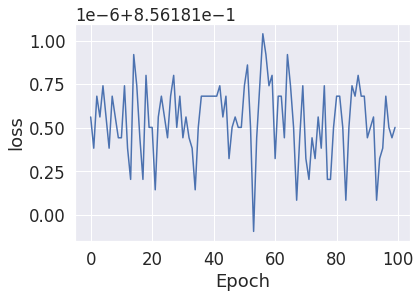

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss="mean_squared_error")

history=model.fit(x=([scaled_n,scaled_z]), y=scaled_target,batch_size=11, epochs=100, shuffle=True, verbose=2)

plt.plot(history.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.show()

In [ ]:
#We extract a keras testset from the .csv file
#Batch_size=11 because it is a divisor of 3377 (could have been 307)
#Talk about pros and cons of small batch size ?
#https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network


test_target = validation_data["BE/A"]
test_n_input = validation_data["N"]
test_z_input = validation_data["Z"]

scaler = MinMaxScaler(feature_range=(0,1))
test_scaled_n = scaler.fit_transform(pd.Series.to_numpy(test_n_input).reshape(-1,1))
test_scaled_z = scaler.fit_transform(pd.Series.to_numpy(test_z_input).reshape(-1,1))
test_scaled_target = scaler.fit_transform(pd.Series.to_numpy(test_target).reshape(-1,1))



In [ ]:
#Predictions thanks to our ANN

validation_predictions = model.predict(x=([test_scaled_n,test_scaled_z]),
                                       batch_size=1, verbose=0)

train_predictions = model.predict(x=([scaled_n,scaled_z]),
                                       batch_size=1, verbose=0)

In [ ]:
rescaled_vp = [(i - scaler.min_)/scaler.scale_ for i in validation_predictions]
rescaled_tp = [(i - scaler.min_)/scaler.scale_ for i in train_predictions]

#Create a new column with the predictions
validation_data["BE/A_Predictions"] = np.double(rescaled_vp)

#Create a new column with the difference between experimental and ANN data
validation_data["BE/A_Difference"] = validation_data["BE/A"] - validation_data["BE/A_Predictions"]

#We do the same for training data
train_data["BE/A_Predictions"] = np.double(rescaled_tp)
train_data["BE/A_Difference"] = train_data["BE/A"] - train_data["BE/A_Predictions"]


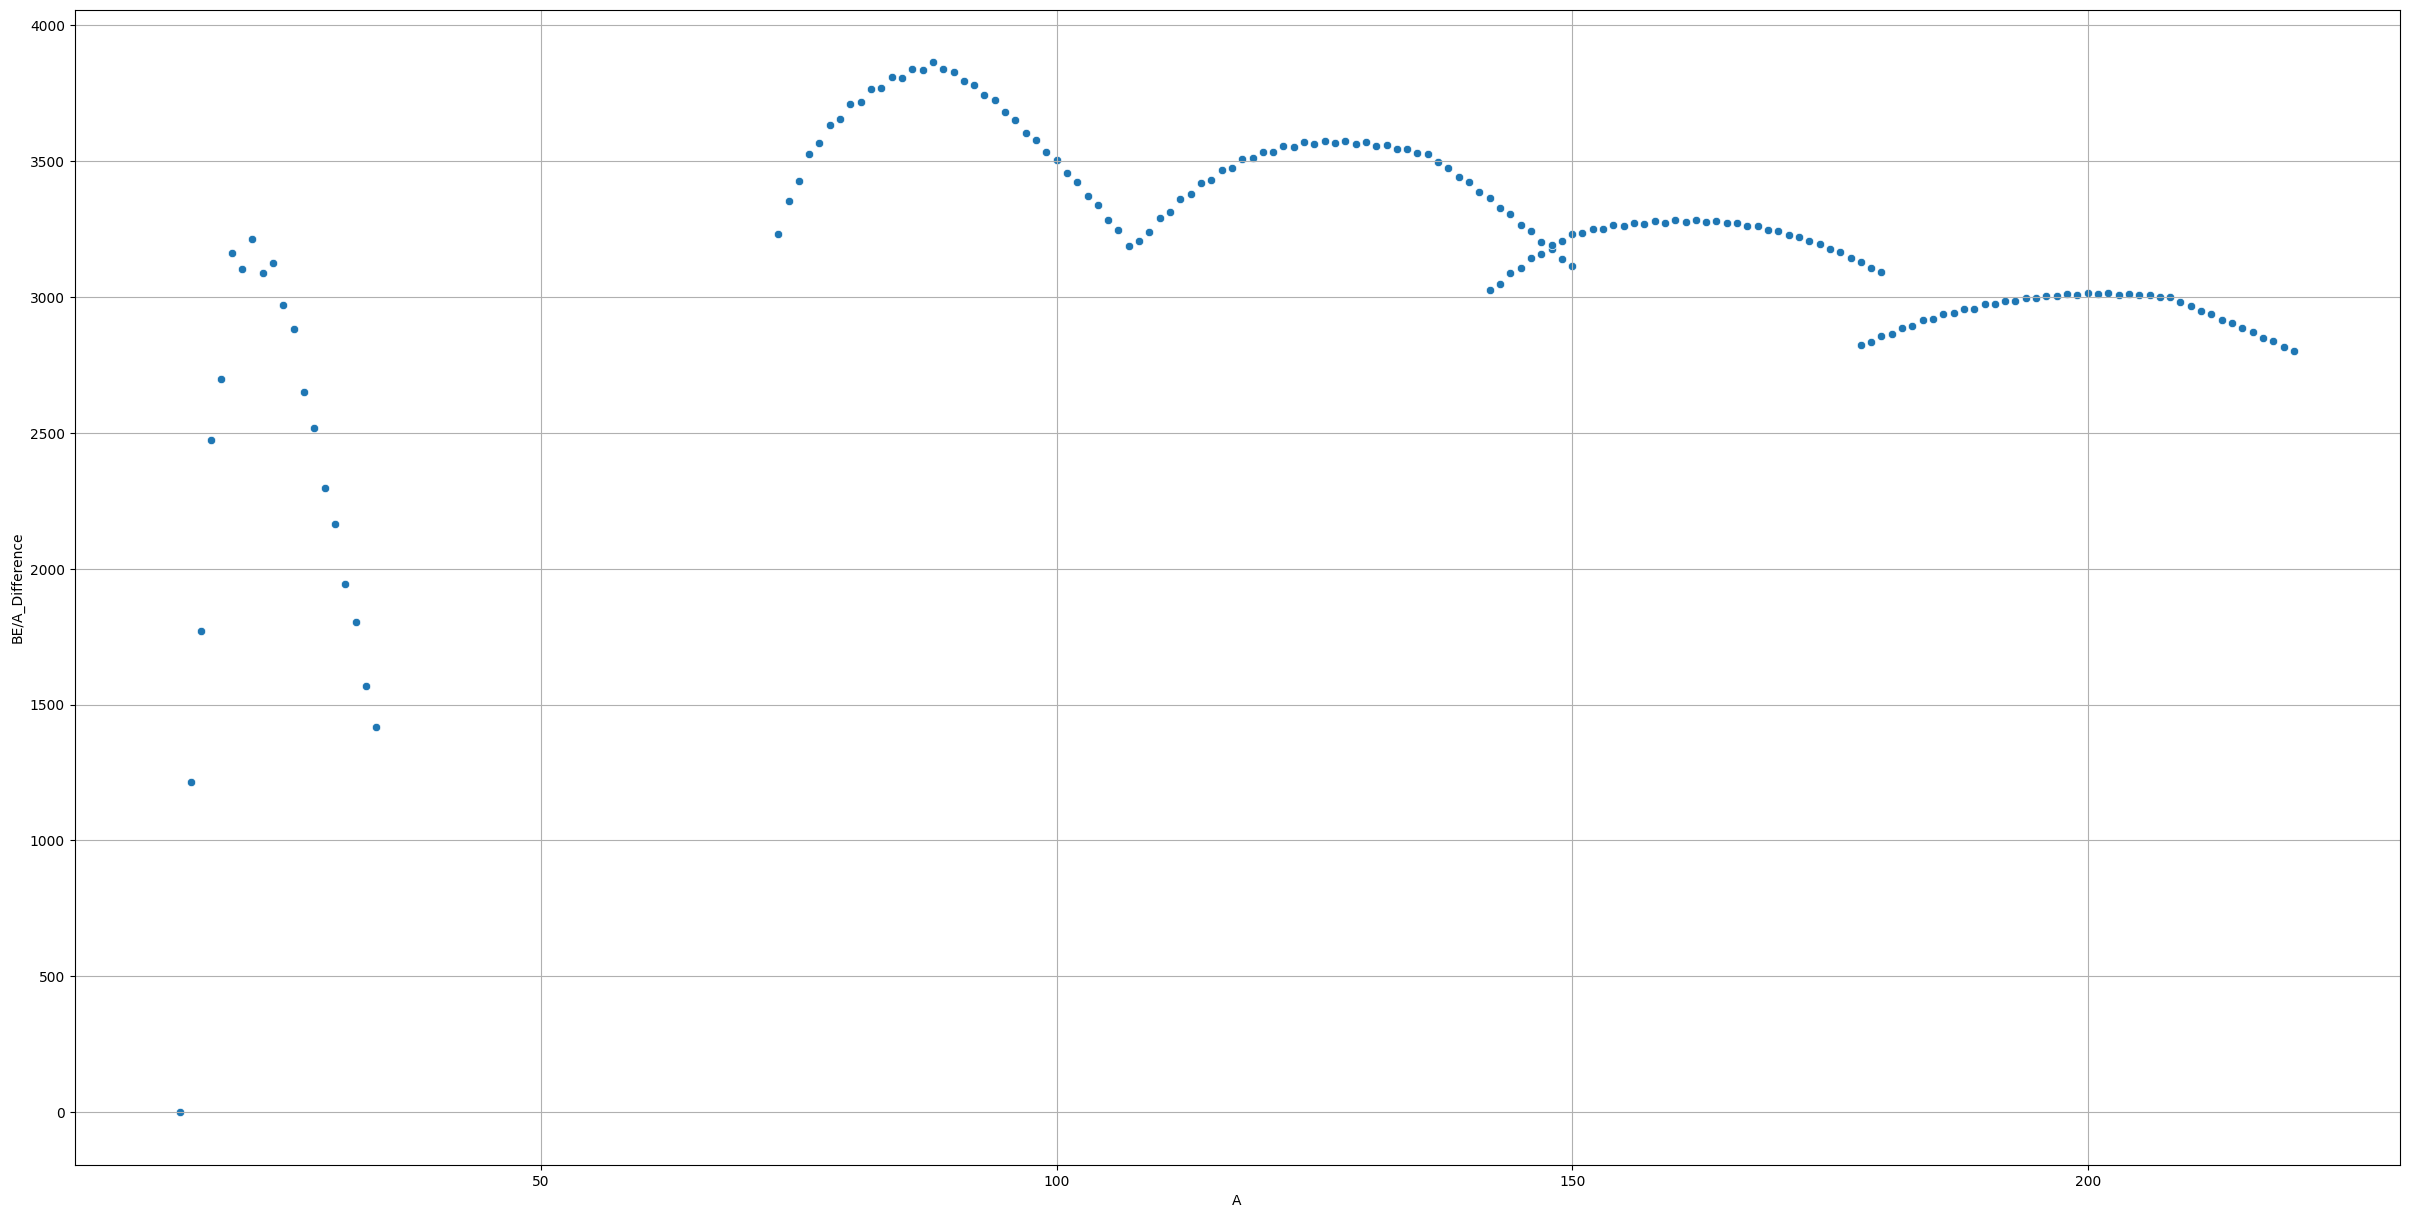

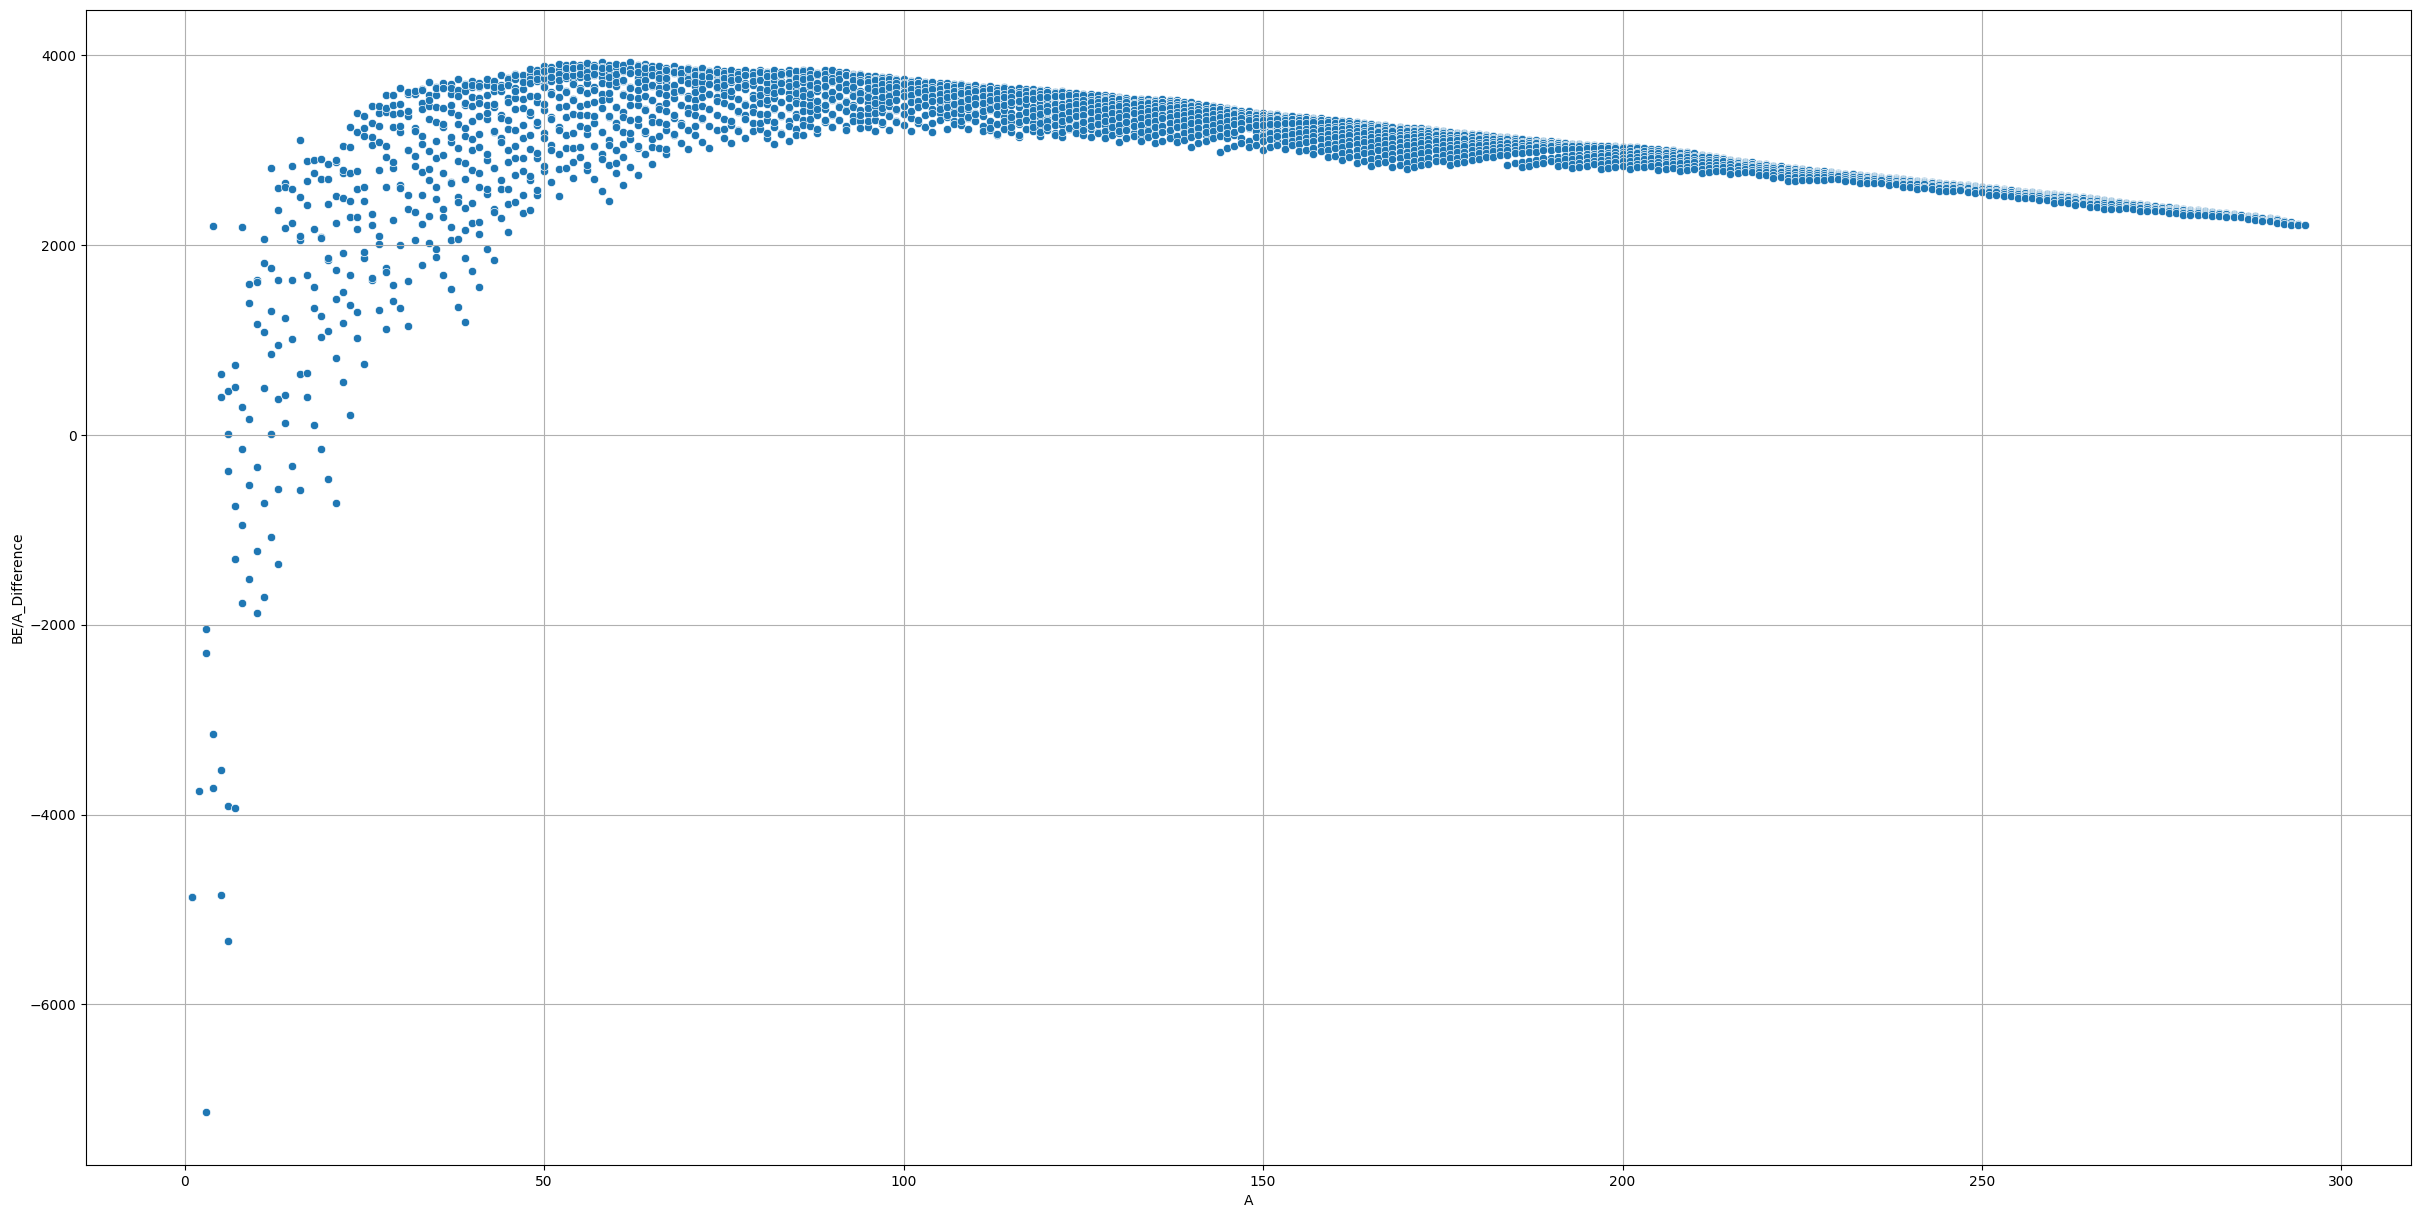

In [ ]:

with plt.style.context('default'):
    plt.figure(figsize =(30,15))
    plt.grid()
    sns.scatterplot(x="A",y="BE/A_Difference", data=validation_data, palette="rainbow_r")
    


with plt.style.context('default'):
    plt.figure(figsize =(30,15))
    plt.grid()
    sns.scatterplot(x="A",y="BE/A_Difference", data=train_data, palette="rainbow_r")

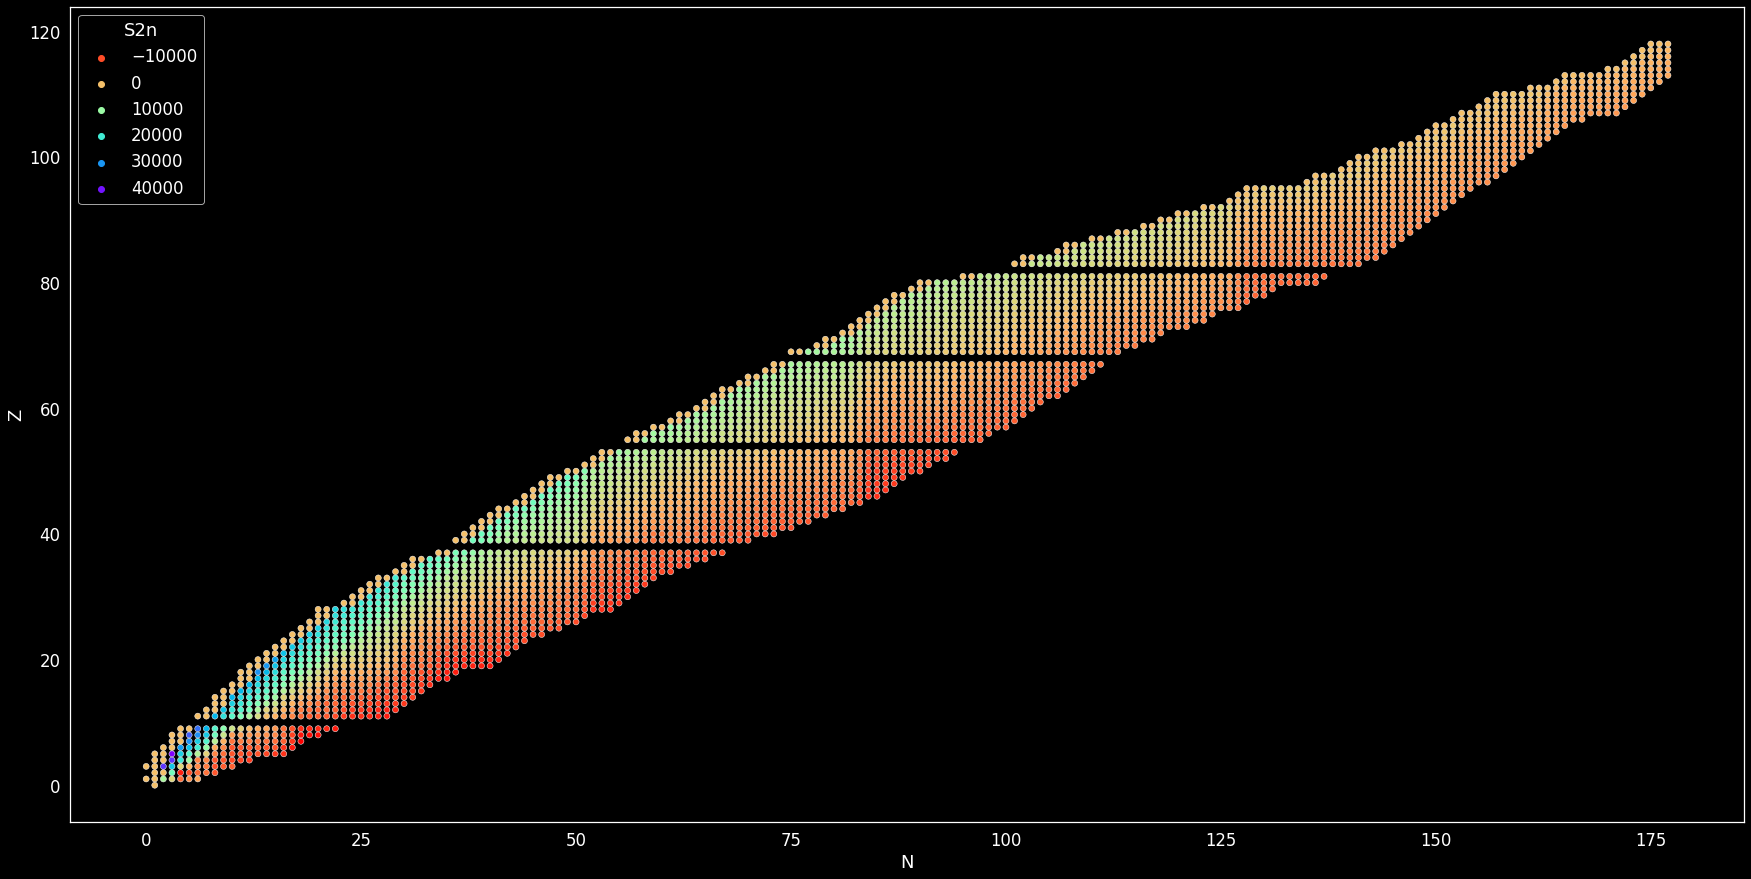

In [ ]:
with plt.style.context('dark_background'):
    plt.figure(figsize =(30,15))
    plt.grid()
    sns.scatterplot(x="N", y="Z", hue="S2n", data=train_data, palette="rainbow_r")

